#Install Libraries

In [2]:
!pip install -U datasets transformers accelerate pandas pyarrow chardet nltk spacy evaluate optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 67.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.9/374.9 kB 19.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 58.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 13.4 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 18.1.0
    Uninstalling pyarrow-18.1.0:
      Successfully uninstalled pyarrow-18.1.0
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfu

In [1]:
!pip install torch==2.8.0 torchvision==0.23.0 torchaudio==2.8.0 transformers==4.44.2 evaluate

#Import Libraries

In [3]:
import torch
import re,string
from transformers import AutoTokenizer, DataCollatorWithPadding
from datasets import load_dataset
from sklearn.model_selection import train_test_split
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
import evaluate
import numpy as np
from peft import LoraConfig, get_peft_model, TaskType
from torch.utils.data import DataLoader
import nltk
import optuna
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [4]:
print('Torch:', torch.__version__)
print('CUDA available:', torch.cuda.is_available())

Torch: 2.8.0+cu126
CUDA available: True


#Load Dataset

In [6]:
#From huggingface
dataset = load_dataset('imdb')
print(dataset)

#Custom
#dataset = load_dataset("csv",data_files={'data':'custom.csv'})['data']
#print(dataset)

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})


In [7]:
#shortening the dataset from 25k train samples to only 5k for faster training.
dataset["train"] = dataset["train"].shuffle(seed=42).select(range(10000))
# dataset["test"] = dataset["test"].shuffle(seed=42).select(range(10000))
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 10000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})


#Clean Data

In [8]:
#drop nulls and fill missing values

In [9]:
re_url=True
re_html=True
re_stopwords=False
lower=True
re_punc=True

urls = re.compile(r"(www\.\S+|https?://\S+)")
htmls = re.compile(r"(<.*?>)")
stopwords = set(stopwords.words("english")) if re_stopwords else set()
punct = str.maketrans("","",string.punctuation)

In [10]:
def clean_text(x):
  if re_url:
    x=urls.sub(" ",x)
  if re_html:
    x=htmls.sub(" ",x)
  if lower:
    x=x.lower()
  if re_stopwords:
    x= " ".join([w for w in x.split() if w not in stopwords])
  if re_punc:
    x=x.translate(punct)
  return x

In [11]:
def apply_clean(batch):
  return {"text":[clean_text(x) for x in batch["text"]]}

In [12]:
dataset=dataset.map(apply_clean,batched=True)
print(dataset["train"][0])

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

{'text': 'there is no relation at all between fortier and profiler but the fact that both are police series about violent crimes profiler looks crispy fortier looks classic profiler plots are quite simple fortiers plot are far more complicated fortier looks more like prime suspect if we have to spot similarities the main character is weak and weirdo but have clairvoyance people like to compare to judge to evaluate how about just enjoying funny thing too people writing fortier looks american but on the other hand arguing they prefer american series  maybe its the language or the spirit but i think this series is more english than american by the way the actors are really good and funny the acting is not superficial at all', 'label': 1}


#Tokenize

In [13]:
model_name_1='bert-base-uncased'
model_name_2='roberta-base'

In [14]:
tokenizer_bert=AutoTokenizer.from_pretrained(model_name_1,use_fast=True)
tokenizer_roberta=AutoTokenizer.from_pretrained(model_name_2,use_fast=True)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [15]:
max_len = 256

def tokenize_bert(batch):
  return tokenizer_bert(batch['text'], truncation=True, max_length=max_len)

def tokenize_roberta(batch):
  return tokenizer_roberta(batch['text'], truncation=True, max_length=max_len)

In [16]:
tokenized_bert = dataset.map(tokenize_bert, batched=True, remove_columns=["text"])
print(tokenized_bert["train"][0:3])

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

{'label': [1, 1, 0], 'input_ids': [[101, 2045, 2003, 2053, 7189, 2012, 2035, 2090, 3481, 3771, 1998, 6337, 2099, 2021, 1996, 2755, 2008, 2119, 2024, 2610, 2186, 2055, 6355, 6997, 6337, 2099, 3504, 15594, 2100, 3481, 3771, 3504, 4438, 6337, 2099, 14811, 2024, 3243, 3722, 3481, 10136, 5436, 2024, 2521, 2062, 8552, 3481, 3771, 3504, 2062, 2066, 3539, 8343, 2065, 2057, 2031, 2000, 3962, 12319, 1996, 2364, 2839, 2003, 5410, 1998, 6881, 2080, 2021, 2031, 17936, 6767, 7054, 3401, 2111, 2066, 2000, 12826, 2000, 3648, 2000, 16157, 2129, 2055, 2074, 9107, 6057, 2518, 2205, 2111, 3015, 3481, 3771, 3504, 2137, 2021, 2006, 1996, 2060, 2192, 9177, 2027, 9544, 2137, 2186, 2672, 2049, 1996, 2653, 2030, 1996, 4382, 2021, 1045, 2228, 2023, 2186, 2003, 2062, 2394, 2084, 2137, 2011, 1996, 2126, 1996, 5889, 2024, 2428, 2204, 1998, 6057, 1996, 3772, 2003, 2025, 23105, 2012, 2035, 102], [101, 2023, 3185, 2003, 1037, 2307, 1996, 5436, 2003, 2200, 2995, 2000, 1996, 2338, 2029, 2003, 1037, 4438, 2517, 2011, 292

In [17]:
tokenized_roberta = dataset.map(tokenize_roberta, batched=True, remove_columns=["text"])
print(tokenized_roberta["train"][0:3])

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

{'label': [1, 1, 0], 'input_ids': [[0, 8585, 16, 117, 9355, 23, 70, 227, 15016, 906, 8, 8546, 10329, 53, 5, 754, 14, 258, 32, 249, 651, 59, 4153, 3474, 8546, 10329, 1326, 32042, 15016, 906, 1326, 4187, 8546, 10329, 21258, 32, 1341, 2007, 15016, 4733, 6197, 32, 444, 55, 6336, 15016, 906, 1326, 55, 101, 2654, 1985, 114, 52, 33, 7, 1514, 20097, 5, 1049, 2048, 16, 3953, 8, 7735, 139, 53, 33, 3741, 2456, 35246, 2389, 82, 101, 7, 8933, 7, 1679, 7, 10516, 141, 59, 95, 6218, 6269, 631, 350, 82, 2410, 15016, 906, 1326, 38187, 260, 53, 15, 5, 97, 865, 7594, 51, 6573, 38187, 260, 651, 1437, 2085, 63, 5, 2777, 50, 5, 4780, 53, 939, 206, 42, 651, 16, 55, 47510, 87, 38187, 260, 30, 5, 169, 5, 5552, 32, 269, 205, 8, 6269, 5, 3501, 16, 45, 34501, 23, 70, 2], [0, 9226, 1569, 16, 10, 372, 5, 6197, 16, 182, 1528, 7, 5, 1040, 61, 16, 10, 4187, 1982, 30, 2458, 11901, 1851, 5, 1569, 2012, 9, 19, 10, 1310, 147, 1368, 3153, 22707, 10, 2214, 19, 10, 6900, 9, 1159, 373, 77, 47, 35672, 110, 14934, 15, 5, 6950, 2

#Padding & Mask

In [18]:
data_collator_bert = DataCollatorWithPadding(tokenizer=tokenizer_bert)
data_collator_roberta = DataCollatorWithPadding(tokenizer=tokenizer_roberta)

In [19]:
train_loader_bert = DataLoader(tokenized_bert["train"], batch_size=8, collate_fn=data_collator_bert, shuffle=True)
train_loader_roberta = DataLoader(tokenized_roberta["train"], batch_size=8, collate_fn=data_collator_roberta, shuffle=True)

In [20]:
batch = next(iter(train_loader_bert))
for k, v in batch.items():
    print(k, v.shape)

input_ids torch.Size([8, 256])
token_type_ids torch.Size([8, 256])
attention_mask torch.Size([8, 256])
labels torch.Size([8])


In [21]:
batch = next(iter(train_loader_roberta))
for k, v in batch.items():
    print(k, v.shape)

input_ids torch.Size([8, 256])
attention_mask torch.Size([8, 256])
labels torch.Size([8])


In [22]:
tokenized_bert.save_to_disk("roberta_dataset")
print("Dataset ready & saved!")

tokenized_roberta.save_to_disk("bert_dataset")
print("Dataset ready & saved!")

Saving the dataset (0/1 shards):   0%|          | 0/10000 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/25000 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/50000 [00:00<?, ? examples/s]

Dataset ready & saved!


Saving the dataset (0/1 shards):   0%|          | 0/10000 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/25000 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/50000 [00:00<?, ? examples/s]

Dataset ready & saved!


#Load Model

In [23]:
model_bert_baseline = AutoModelForSequenceClassification.from_pretrained(model_name_1, num_labels=2)
model_roberta_baseline = AutoModelForSequenceClassification.from_pretrained(model_name_2, num_labels=2)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


#Metrics

In [24]:
acc_metric = evaluate.load("accuracy")
f1_metric = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": acc_metric.compute(predictions=preds, references=labels),
        "f1": f1_metric.compute(predictions=preds, references=labels, average="weighted")
    }

#LoRA Setup

In [39]:
lora_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    r=16,
    lora_alpha=32,
    lora_dropout=0.05
)

In [40]:
model_bert = get_peft_model(model_bert_baseline, lora_config)
model_roberta = get_peft_model(model_roberta_baseline, lora_config)

/usr/local/lib/python3.12/dist-packages/peft/mapping_func.py:73: UserWarning: You are trying to modify a model with PEFT for a second time. If you want to reload the model with a different config, make sure to call `.unload()` before.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/peft/tuners/tuners_utils.py:196: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/peft/mapping_func.py:79: UserWarning: The PEFT config's `base_model_name_or_path` was renamed from 'bert-base-uncased' to 'roberta-base'. Please ensure that the correct base model is loaded when loading this checkpoint.
  warnings.warn(


In [41]:
model_bert.print_trainable_parameters()

trainable params: 591,362 || all params: 110,075,140 || trainable%: 0.5372


In [42]:
model_roberta.print_trainable_parameters()

trainable params: 1,181,954 || all params: 125,829,124 || trainable%: 0.9393


#Training Setup

In [43]:
def train_model(model, tokenizer, train_dataset, val_dataset, model_name):
    training_args = TrainingArguments(
        output_dir=f"./{model_name}_results",
        eval_strategy="epoch",
        save_strategy="epoch",
        learning_rate=2e-4,
        per_device_train_batch_size=16,
        gradient_accumulation_steps=8,
        num_train_epochs=3,
        load_best_model_at_end=True,
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=compute_metrics,
        tokenizer=tokenizer,
    )

    trainer.train()
    metrics = trainer.evaluate()
    return trainer, metrics

#Training

In [44]:
bert_trainer, bert_metrics = train_model(model_bert, tokenizer_bert, tokenized_bert["train"], tokenized_bert["test"], "bert")
roberta_trainer, roberta_metrics = train_model(model_roberta, tokenizer_roberta, tokenized_roberta["train"], tokenized_roberta["test"], "roberta")

/tmp/ipython-input-4075538237.py:13: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.306002,{'accuracy': 0.87548},{'f1': 0.8753923621523823}
2,No log,0.268719,{'accuracy': 0.89048},{'f1': 0.8904402822358205}
3,No log,0.260486,{'accuracy': 0.89312},{'f1': 0.8930841166346267}


Trainer is attempting to log a value of "{'accuracy': 0.87548}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'f1': 0.8753923621523823}" of type <class 'dict'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
You are using a model of type roberta to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
/usr/local/lib/python3.12/dist-packages/peft/utils/save_and_load.py:300: UserWarning: Setting `save_embedding_layers` to `True` as the embedding layer has been resized during finetuning.
  warnings.warn(
Trainer is attempting to log a value of "{'accuracy': 0.89048}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped t

Trainer is attempting to log a value of "{'accuracy': 0.89312}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'f1': 0.8930841166346267}" of type <class 'dict'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
/tmp/ipython-input-4075538237.py:13: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.200097,{'accuracy': 0.92076},{'f1': 0.9207516251585441}
2,No log,0.184499,{'accuracy': 0.92804},{'f1': 0.9280380839708087}
3,No log,0.184257,{'accuracy': 0.92804},{'f1': 0.9280353480897571}


Trainer is attempting to log a value of "{'accuracy': 0.92076}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'f1': 0.9207516251585441}" of type <class 'dict'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'accuracy': 0.92804}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'f1': 0.9280380839708087}" of type <class 'dict'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'accuracy': 0.92804}" of type <class 'dict'> for key "eval/accuracy" as a scalar

Trainer is attempting to log a value of "{'accuracy': 0.92804}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'f1': 0.9280353480897571}" of type <class 'dict'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


#Evaluation

In [45]:
print("BERT metrics:", bert_metrics)
print("RoBERTa metrics:", roberta_metrics)

BERT metrics: {'eval_loss': 0.2604861557483673, 'eval_accuracy': {'accuracy': 0.89312}, 'eval_f1': {'f1': 0.8930841166346267}, 'eval_runtime': 110.2758, 'eval_samples_per_second': 226.704, 'eval_steps_per_second': 28.338, 'epoch': 3.0}
RoBERTa metrics: {'eval_loss': 0.18425728380680084, 'eval_accuracy': {'accuracy': 0.92804}, 'eval_f1': {'f1': 0.9280353480897571}, 'eval_runtime': 106.733, 'eval_samples_per_second': 234.229, 'eval_steps_per_second': 29.279, 'epoch': 3.0}


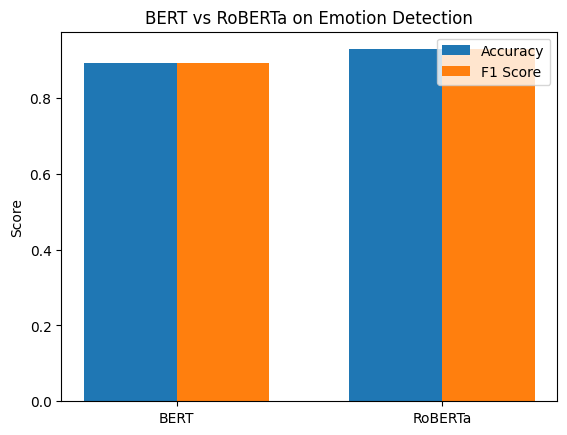

In [46]:
import matplotlib.pyplot as plt

models = ["BERT", "RoBERTa"]

accuracies = [bert_metrics["eval_accuracy"]["accuracy"], roberta_metrics["eval_accuracy"]["accuracy"]]
f1s = [bert_metrics["eval_f1"]["f1"], roberta_metrics["eval_f1"]["f1"]]

x = range(len(models))
width = 0.35

plt.bar([i - width/2 for i in x], accuracies, width=width, label="Accuracy")
plt.bar([i + width/2 for i in x], f1s, width=width, label="F1 Score")

plt.xticks(x, models)
plt.ylabel("Score")
plt.title("BERT vs RoBERTa on Emotion Detection")
plt.legend()
plt.show()